## Import icbhi-preprocessing-v4 data before running

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pandas as pd

# Not immediately usable with this dataset as files contain 24-bit data
from scipy.io import wavfile
from scipy.io.wavfile import read, write

import IPython.display as ipd
from IPython.display import Audio
from numpy.fft import fft, ifft

import librosa as lr
import librosa.display

import os
import pickle
from glob import glob

import seaborn as sns

from scipy import signal as sig
from scipy.signal import butter, lfilter, sosfilt
from scipy.fftpack import fft, ifft
from tqdm import tqdm
import pywt
import random
import skimage.data
from skimage.restoration import denoise_wavelet
from pywt import swt
import time as tm
import collections
from typing import Tuple
from typeguard import typechecked

# if ('pydub' in globals()) == False:
#   !pip install pydub
# from pydub import AudioSegment
# from pydub.utils import make_chunks


# LT-06-24: import io to save intermediate outputs; use "as" to shorten module.function name as "spio"
import scipy.io as spio


# LT-06-24: install modules if not found 
# if ( 'umap' in globals() ) == False: 
#   !pip install umap-learn

import umap.umap_ as umap

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

print('Importing done')

Importing done


# Preprocessed Data

In [2]:
prepro_slices = np.load("../input/icbhi-preprocessing-v4/prepro_slices.npy")

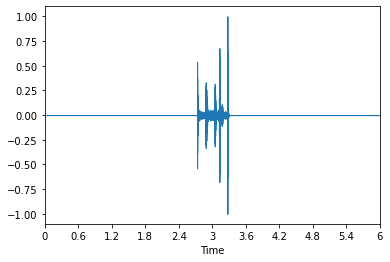

In [3]:
lr.display.waveplot(prepro_slices[0], sr=8000);
plt.xlim([0,6]);

# Extraction
### Evaluation of features for classification of lung diseases (Tasar et al., 2021)

In [4]:
@typechecked
def check_params(q: float, redundancy: float, stages: int):
    if q < 1:
        raise ValueError("q must be greater or equal 1!")
    if redundancy <= 1:
        raise ValueError("The redundancy must be strictly greater than 1")
    if stages < 1:
        raise ValueError("stages must be a positive integer!")

In [5]:
def tqwt(x: np.ndarray, q: float, redundancy: float, stages: int) -> np.ndarray:
    """
    Tunable-Q Wavelet transform
    Parameters
    ----------
    x: array like, shape (n,)
        Input signal, needs to be of even length
    q: float
        Q-Factor. The Q-factor, denoted Q, affects the oscillatory behavior the wavelet; specifically, Q affects the
        extent to which the oscillations of the wavelet are sustained. Roughly, Q is a measure of the number of
        oscillations the wavelet exhibits. For Q, a value of 1.0 or greater can be specified. The definition of the
        Q-factor of an oscillatory pulse is the ratio of its center frequency to its bandwidth.
    redundancy: float
        Oversampling rate (redundancy). Redundancy of the TQWT when it is computed using
        infinitely many levels. Here `redundancy means total over-sampling rate of the transform (the total number of
        wavelet coefficients divided by the length of the signal to which the TQWT is applied.) The specified value of
        must be greater than 1.0, and a value of 3.0 or greater is recommended. (When it is close to 1.0, the wavelet
        will not be well localized in time — it will have excessive ringing which is generally considered undesirable.)
        The actual redundancy will be somewhat different than the parameter because the transform can actually be
        computed using only a finite number of levels.
    stages: int
        The number of stages (or levels) of the wavelet transform is denoted by stages. The transform consists of a
        sequence of two-channel filter banks, with the low-pass output of each filter bank being used as the input to
        the successive filter bank. The parameter `stages` denotes the number of filter banks. Each output signal
        constitutes one subband of the wavelet transform. There will be J + 1 subbands: the high-pass filter output
        signal of each filter bank, and the low-pass filter output signal of the final filter bank.
    Returns
    -------
    w: np.ndarray with dtype np.object
        Wavelet coefficients.
    """
    check_params(q, redundancy, stages)
    if x.shape[0] % 2 or len(x.shape) != 1:
        raise ValueError("Input signal x needs to be one dimensional and of even length!")
    x = np.asarray(x)

    beta = float(2 / (q + 1))
    alpha = float(1 - beta / redundancy)
    n = x.shape[0]

    max_num_stages = int(np.floor(np.log(beta * n / 8) / np.log(1 / alpha)))

    if stages > max_num_stages:
        if max_num_stages > 0:
            raise ValueError("Too many subbands, reduce subbands to " + str(max_num_stages))
        else:
            raise ValueError("Too many subbands specified, increase signal length")

    fft_of_x = fft(x) / np.sqrt(n)  # unitary DFT

    w = []                          # init list of wavelet coefficients

    for subband_idx in range(1, stages + 1):
        n0 = 2 * round(alpha ** subband_idx * n / 2)
        n1 = 2 * round(beta * alpha ** (subband_idx - 1) * n / 2)
        fft_of_x, w_subband = analysis_filter_bank(fft_of_x, n0, n1)
        w.append(ifft(w_subband) * np.sqrt(len(w_subband)))  # inverse unitary DFT

    w.append(ifft(fft_of_x) * np.sqrt(len(fft_of_x)))      # inverse unitary DFT
    return np.array(w, dtype=np.object)


def analysis_filter_bank(x: np.ndarray, n0: int, n1: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Two-channel analysis filter bank operating on a frequency domain input x. This function is used
    iteratively by `tqwt`.
    Parameters
    ----------
    x: np.ndarray
        Input vector (frequency domain)
    n0: int
        length of the lp_subband
    n1: int
        length of the hp_subband
    Returns
    -------
    lp_subband: np.ndarray
        low-pass output of the filter bank in the frequency domain
    hp_subband: np.ndarray
        high-pass output of the filter bank in the frequency domain
    """
    x = np.array(x)
    n = x.shape[0]                  # len(x)

    p = int((n-n1) / 2)             # pass-band
    t = int((n0 + n1 - n) / 2 - 1)  # transition-band
    s = int((n - n0) / 2)           # stop-band

    # transition band function
    v = np.arange(start=1, stop=t+1) / (t+1) * np.pi
    transit_band = (1 + np.cos(v)) * np.sqrt(2 - np.cos(v)) / 2.0

    # low-pass subband
    lp_subband = np.zeros(n0, dtype=x.dtype)
    lp_subband[0] = x[0]                                                  # DC-term
    lp_subband[1:p+1] = x[1:p + 1]                                        # pass-band
    lp_subband[1+p:p+t+1] = x[1 + p:p + t + 1] * transit_band             # transition-band
    lp_subband[int(n0 / 2)] = 0                                           # nyquist
    lp_subband[n0-p-t:n0-p] = x[n - p - t:n - p] * np.flip(transit_band)  # transition-band (negative frequencies)
    lp_subband[n0-p:] = x[n - p:]                                         # pass-band (negative frequencies)

    # high-pass subband
    hp_subband = np.zeros(n1, dtype=x.dtype)
    hp_subband[0] = 0                                                     # DC-term
    hp_subband[1:t+1] = x[1 + p:t + p + 1] * np.flip(transit_band)        # transition-band
    hp_subband[t+1:s+1+t] = x[p + t + 1:p + t + s + 1]                    # pass-band
    if n // 2 == 0:                                                       # nyquist if N is even
        hp_subband[n1/2] = x[n / 2]
    hp_subband[n1-t-s-1:n1-t] = x[n - p - t - s - 1:n - p - t]            # pass-band (negative frequencies)
    hp_subband[n1-t:n1] = x[n - p - t:n - p] * transit_band               # transition-band (negative frequencies)

    return lp_subband, hp_subband

In [6]:
def extract(signal, sr=8000):
    """
    signal: slice that has already undergone preprocessing
    sr: sampling rate of slice
    """
#     # Spectrograms
#     stft = lr.stft(signal)
#     spec = lr.amplitude_to_db(abs(stft))
    
# #     # Spectral centroids
# #     cent = lr.feature.spectral_centroid(signal, sr, n_fft=512, hop_length=256)[0]
    
#     # Mel-cepstral frequency coefficients
#     mfcc = lr.feature.mfcc(signal, sr, n_mfcc=13)
    
#     # Wavelet transform using Baubechies with 4 vanishing moments
#     modwt = np.array(pywt.dwt(signal, 'db4', mode='zero'))
# #     # Absolute mean
# #     abm = abs(np.nanmean(modwt))
# #     # Standard deviation
# #     sd = np.nanstd(modwt)
#     # Zero crossing rate
#     wt_zcr = len(np.nonzero(np.diff(np.array(modwt) > 0))[0])
    
    tqwts = tqwt(signal, 1.0, 2.0, 8)
    
    return tqwts

In [7]:
def save_extraction(preprocessed_slices):
    for i, signal in enumerate(preprocessed_slices):
        # Extract
        wave_transform = extract(signal)
        
        # Reshape
#         a,b = spec.shape
#         c,d = mfcc.shape
#         spec = spec.reshape((a*b))
#         mfcc = mfcc.reshape((c*d))
#         features = np.hstack((spec, mfcc, wt_zcr))
        
        # Naming
        filename = str(i) + '_features.npy'
        
        np.save(filename, wave_transform)
        
    return print('done')

In [8]:
# def save_specific_extraction( i, demo=0 ):
#     signal  = prepro_slices[i, ]
#     # Extract
#     spec, mfcc, wt_zcr = extract(signal )

#     # Reshape
#     a,b = spec.shape
#     c,d = mfcc.shape
#     spec = spec.reshape((a*b))
#     mfcc = mfcc.reshape((c*d))
#     features = np.hstack((spec, mfcc, wt_zcr))

#     # Naming
#     filename = str(i) + '_features' + '.npy'

    
#     np.save(filename, features)       
#     z=[]
#     if demo:
#         # l1,l2,l3 = spec.shape, mfcc.shape, wt_zcr.shape
#         z=[len(spec),len(mfcc),1]
#     return signal, z
# signal, z = save_specific_extraction( 121, 1 )
# print(z)    

In [9]:
def load_all_files(directory):
    files = list(map(lambda p: os.path.splitext(os.path.basename(p))[0],
                    glob(os.path.join(directory, '*.npy'))))
    
    samples = {}
    for filename in files:
        samples[filename] = np.load(os.path.join(directory, filename + '.npy'))
    return samples    

In [10]:
# check file count 
# from glob import glob
# f=sorted( glob('../input/icbhi-extraction-v2/*npy') )
# print( len(f), len(class_list) )

    

In [11]:
# directory = '../input/icbhi-extraction-v2/' 
# nsamples = len(class_list)
# features = np.zeros( (1000, 536647) )
# subset = np.zeros( 1000 ).astype(int)

# inc=-1
# for d in range( 0, nsamples, nsamples//100 ):
#     try: # quick hack to read some        
#         inc+=1 
#         subset[inc] = class_list[d] 
#         print(inc, subset[inc], end=', ' )
#         features[inc,:] = np.load(directory+ '%d_features.npy' % d )
#     except:
#         break


In [12]:
# plt.plot(subset, 'r')

In [13]:
# plt.plot( features[0,529925: ] );

In [14]:
# plt.plot( features[21,529925: ] );


In [15]:
if os.path.exists('../input/icbhi-extraction-v4/0_features.npy'):
    print('loaded')
    features = load_all_files('../input/icbhi-extraction-v4')
else:
    print('saved')
    save_extraction(prepro_slices)

saved
done


In [16]:
# n = len(class_list)

In [17]:
# ordered_classes = np.zeros(n).astype(int)
# for i, key in enumerate(features.keys()):
#     index = int(key.split('_')[0])
#     ordered_classes[i] = class_list[index]
# ordered_classes

In [18]:
# features = list(features.values())